# 1. Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Loading the dataset as a pandas dataframe
dfraw = pd.read_csv('Kaggle_Salary.csv', header = [0,1], low_memory = False)
df = dfraw
print("Number of samples:", df.shape[0])

Number of samples: 15429


First, I took a look at the questions asked in the survey.

In [3]:
# Print out survey questions in readable format
qnum = 0
lastNum = 0
for question in df.columns:
    try:
        qnum = question[0].split('Q')[1]
    except:
        pass
    try:
        qnum = qnum.split('_')[0]
    except:
        pass
    qnum = int(qnum)
    if qnum > lastNum:
        print(qnum, question[1].split('?')[0], "?")
        lastNum = qnum

1 What is your gender ?
2 What is your age (# years) ?
3 In which country do you currently reside ?
4 What is the highest level of formal education that you have attained or plan to attain within the next 2 years ?
5 Which best describes your undergraduate major ?
6 Select the title most similar to your current role (or most recent title if retired): - Selected Choice ?
7 In what industry is your current employer/contract (or your most recent employer if retired) ?
8 How many years of experience do you have in your current role ?
9 What is your current yearly compensation (approximate $USD) ?
10 Does your current employer incorporate machine learning methods into their business ?
11 Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions ?
12 What is the primary tool that you use at work or school to analyze data ?
13 Which of the following integrated de

After reviewing the survey questions, I decided to drop the following columns:

- Columns with opinion related questions (eg. What programming language would you recommend an aspiring data scientist to learn first?) since it won't help with the salary prediction. (ie.'Q18','Q33','Q38','Q39','Q40','Q41','Q42','Q44','Q45','Q47','Q48','Q49','Q50')
- Columns with text responses as no key column was available to match up the responses to the surveyee
- "Other" option for "Select all that apply" questions since that will be automatically captured if none of the other options were selected
- The index columns
- Duration of survey, since there was no reward for completing the survey, it was assumed that respondents did not just randomly answer the questions for the sake of completion.  It should not have any correlation with the predicted salary.

In [4]:
dropCols = ['Q18','Q26','Q33','Q38','Q39','Q40','Q41','Q42','Q44','Q45','Q47','Q48','Q49','Q50','Q32_OTHER','Other - Text','OTHER_TEXT','Q12_Part_','Unnamed: 0_level_0','index','Time from Start to Finish']
for q in dropCols:
    df = df.drop(list(df.filter(regex = q)), axis = 1)

Many of the questions allow the surveyee to select any option that applies.  Here, I identified those column names which will be used shortly.

In [5]:
# Get column names for questions with "Select all that apply" option
selectColumns = list(df.filter(regex = "Select all that apply"))
selectCols = []
for coltuple in selectColumns:
    selectCols.append(coltuple[0])

In [6]:
df.columns = df.columns.droplevel(-1) # Remove second header (question descriptions) for easier indexing

I then took a look in detail of the responses options for question 1 to question 8.  I removed all samples that did not have an explicit answer, such as "other", or "I prefer not to say" since the machine learning algorithm would treat those responses as features.  I also dropped all samples that were Nan because these questions are very critically in predicted the yearly compensation.

In [7]:
# Drop samples with inexplicit answers
df = df[~df['Q1'].isin(['Prefer not to say', 'Prefer to self-describe'])] # Gender
df = df[~df['Q3'].isin(['Other', 'I do not wish to disclose my location'])] # Country
df = df[~df['Q4'].isin(['I prefer not to answer'])] # Highest Education
df = df[~df['Q5'].isin(['Other', 'I never declared a major'])] # Major
df = df[~df['Q6'].isin(['Other'])] # Title
df = df[~df['Q7'].isin(['Other'])] # Industry
df = df.dropna(subset = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8']) # Drop all samples with no answer 

print("Number of samples:", df.shape[0])

Number of samples: 12199


I then took a look at the number of NaN responses for all other columns with categorical responses.  All questions except Q10 had between 10% to 52% samples that didn't answer.  With such a significant portion of the samples missing responses, it would not be a good idea to simple just impute the values.  I reviewed the questions and determined that they did not have significant relation to predicting the yearly compensation, therefore I decided to drop all the questions except for Q10.

In [8]:
print("Missing values for columns with categorical responses")
print(df.drop(selectCols, axis = 1).isna().sum()) 

Missing values for columns with categorical responses
Q1                        0
Q2                        0
Q3                        0
Q4                        0
Q5                        0
Q6                        0
Q7                        0
Q8                        0
Q9                        0
Q10                     235
Q12_MULTIPLE_CHOICE    1245
Q17                    3251
Q20                    4360
Q22                    4762
Q23                    1532
Q24                    1548
Q25                    1569
Q32                    3964
Q34_Part_1             2803
Q34_Part_2             2803
Q34_Part_3             2803
Q34_Part_4             2803
Q34_Part_5             2803
Q34_Part_6             2803
Q35_Part_1             2906
Q35_Part_2             2906
Q35_Part_3             2906
Q35_Part_4             2906
Q35_Part_5             2906
Q35_Part_6             2906
Q37                    6369
Q43                    4310
Q46                    4202
dtype: int64


For Q10, since there were only 1.9% samples with missing responses, I decided to impute the missing values with the mode.

In [9]:
# Impute Q10s missing values with the mode
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
Q10_imputed = imp_mode.fit_transform(df['Q10'].values.reshape(-1, 1))
df['Q10'] = Q10_imputed

In [10]:
df = df[['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10'] + selectCols] # Drop all categorical columns except Q1 to Q10

For the "Select all that apply" columns, they technically have already been one-hot-encoded since each response has it's own column, with the selected choice as the responses or NaN if it wasn't selected.  So all I did was replace the selected choice with "1" and the Nan with "0".  So now these responses are like a binary feature.

In [11]:
# Replace non-empty values with 1 and nan values with 0 for "Select all that apply" columns
df[selectCols] = df[selectCols].notnull().astype('int') 

For the gender column (Q1), after the cleaning above there were only "Male" and "Female" responses remaining.  Therefore all I needed to do was encode the values as a binary feature.

In [12]:
# Encode gender column with 0 and 1, not required to do one-hot encoding since it's binary
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Q1_encoded = le.fit_transform(df['Q1'])
df['Q1'] = Q1_encoded

For the age (Q2), degree (Q4), and the target column (Q9) it is a little bit different because these features are ordinary, meaning the categories are hierarchical.  If I just encode than randomly with integers, I would lose the hierarchical information.  Therefore, I decided to manually encode the categories as 0,1,2,3... etc from lowest to highest.

In [13]:
# Encoding features with hierarchical categorigories as 0,1,2,3... 
ageBins = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70-79','80+']

for c,i in enumerate(ageBins):
    df['Q2'] = df['Q2'].replace(i,c)
    
salaryBins = ['0-10,000','10-20,000','20-30,000','30-40,000','40-50,000','50-60,000','60-70,000','70-80,000','80-90,000','90-100,000','100-125,000','125-150,000','150-200,000','200-250,000','250-300,000','300-400,000','400-500,000','500,000+']

for c,i in enumerate(salaryBins):
    df['Q9'] = df['Q9'].replace(i,c)

degreeBins = ['Some college/university study without earning a bachelor’s degree','Bachelor’s degree','Professional degree','Master’s degree','Doctoral degree']

for c,i in enumerate(degreeBins):
    df['Q4'] = df['Q4'].replace(i,c)

In [14]:
labels = df['Q9'] # Save the yearly compensations as "labels" dataframe series
df2 = df.drop('Q9', axis = 1) # Drop the target labels from the dataframe

Now the only columns remaining are the non-hierarchical features.  For these, I chose to use one-hot-encoding, which creates a new binary feature for each category in the original feature.  There is also an encoding method called dummy encoding, which gives me k-1 columns by dropping one of the encoded columns since the category could be inferred from the other ones.  I chose not to do that because I will be doing automatic feature selection later and if some of the one-hot-encoded columns are dropped, it would group all the categories to the inferred column, which is not what is desired.  Please note that the get_dummies method is actually one-hot-encoding as I did not specify the parameter "drop_first" as True.

In [15]:
# Create one-hot-encoded feature columns and dropping the original columns
catdf = df2.select_dtypes(include = 'object')
oneHots = pd.get_dummies(catdf)
features = df2.drop(catdf.columns, axis = 1)
features = features.join(oneHots)

# 2. Exploratory data analysis

Next, I performed exploratory data analysis.  First, I took look at the distribution of the target category, ie. the Yearly Compensation using a histogram.  You can see that the data is highly imbalanced, with the majority of the samples belong in the lowest salary brackets.  This means that our data is sparse, and predicting higher salaries would be difficult as there are way fewer training examples.  Because of this imbalance, it is important to note that we should also check the recall score when testing since the model may only be very good at predicted low salaries.  

In [16]:
import matplotlib.pyplot as plt
_ = plt.figure(figsize = (16,6))
_ = plt.title("Histogram of Yearly Compensation in Data")
_ = plt.xlabel("Yearly Compensation (approximate $USD)")
_ = plt.xticks(np.arange(18), salaryBins, rotation='vertical')
_ = plt.ylabel("Count")
_ = df['Q9'].hist(bins = 18, grid = False)

Here, I took a look at the correlation between the age and the median yearly compensation.  You can see a clear trend that the median salary increases as the age increases up to about 60-69 then sharply decreases.  This makes sense as I expect more experienced data scientists to be paid more up to about retirement age.

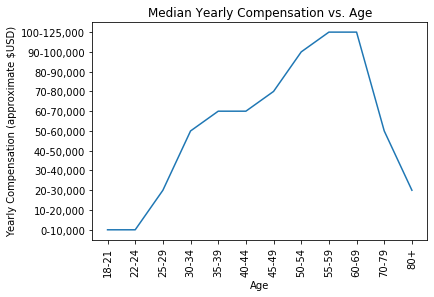

In [17]:
medsalbyage = df.groupby(['Q2'])['Q9'].median().values
_ = plt.title("Median Yearly Compensation vs. Age")
_ = plt.xlabel("Age")
_ = plt.xticks(np.arange(12), ageBins, rotation = 'vertical')
_ = plt.ylabel("Yearly Compensation (approximate $USD)")
_ = plt.yticks(np.arange(18), salaryBins)
_ = plt.plot(medsalbyage)

Here I took a look at the median yearly compensation grouped by country.  USA is the highest, which makes sense as it is where big technology companies requiring data scientists reside (eg. Facebook, Google, Twitter).  You can see a trend that generally the high median salary countries are also those with high standards of living, which is expected as income is correlated with living costs.  

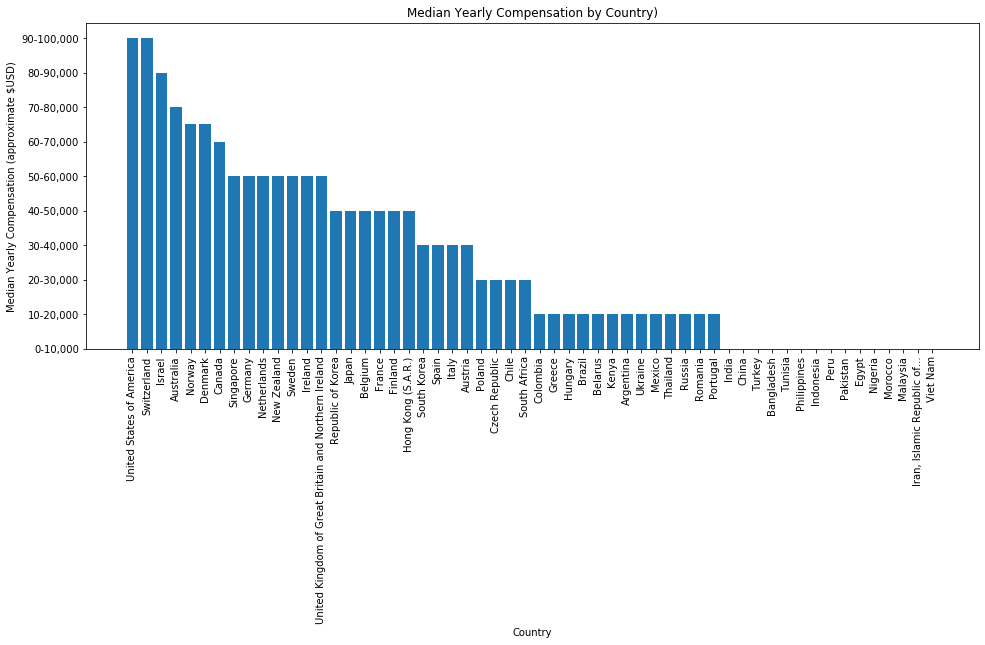

In [18]:
medsalbycountry = df.groupby(['Q3'])['Q9'].median().sort_values(ascending = False)
countrylabels = list(medsalbycountry.to_dict().keys())
medsalbycountry = medsalbycountry.values
_ = plt.figure(figsize = (16,6))
_ = plt.title("Median Yearly Compensation by Country)")
_ = plt.xlabel("Country")
_ = plt.xticks(rotation = 90)
_ = plt.ylabel("Median Yearly Compensation (approximate $USD)")
_ = plt.yticks(np.arange(18), salaryBins)
_ = plt.bar(x = countrylabels, height = medsalbycountry)

Here I took a look at the education level compared to the median yearly compensation.  We can see a clear trend that the higher the education, the higher the compensation.  

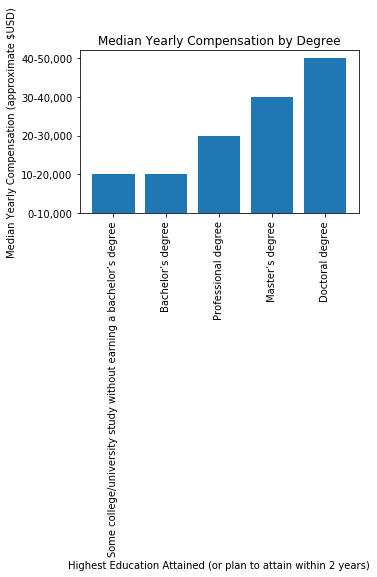

In [19]:
medsalbydegree = df.groupby(['Q4'])['Q9'].median().sort_values(ascending = True)
medsalbydegree = medsalbydegree.values
_ = plt.figure(figsize = (5,3))
_ = plt.title("Median Yearly Compensation by Degree")
_ = plt.xlabel("Highest Education Attained (or plan to attain within 2 years)")
_ = plt.xticks(rotation = 90)
_ = plt.ylabel("Median Yearly Compensation (approximate $USD)")
_ = plt.yticks(np.arange(18), salaryBins)
_ = plt.bar(x = degreeBins, height = medsalbydegree)

Here I took a look at the correlation between the university major and median yearly compensation.  I would expect those with a major in math & stats, computer science, or engineering to have the highest salary but here the highest earners are those with a major in Humanities and Fine Arts.  I hypothesize that it's because most respondents with math & stats, computer science, or engineering majors are from low income countries.  Therefore, I will remake this graph and filter it for only USA and Canada which have similar standard of living.  

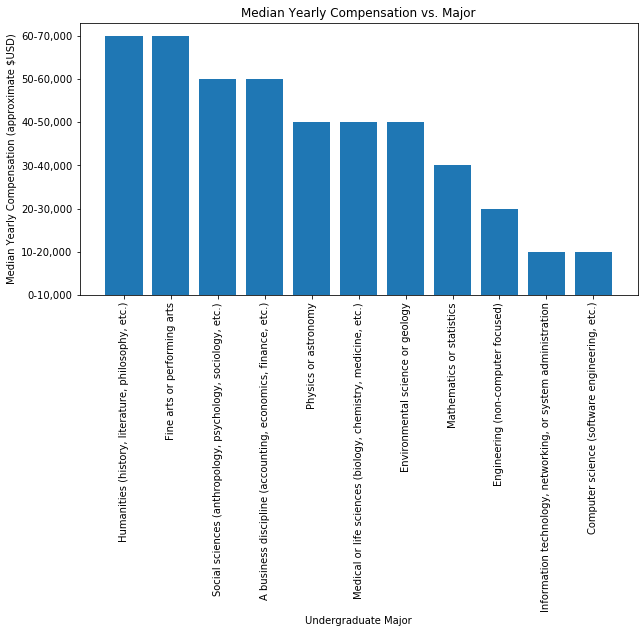

In [20]:
medsalbymajor = df.groupby(['Q5'])['Q9'].median().sort_values(ascending = False)
majorlabels = list(medsalbymajor.to_dict().keys())
medsalbymajor = medsalbymajor.values
_ = plt.figure(figsize = (10,5))
_ = plt.title("Median Yearly Compensation vs. Major")
_ = plt.xlabel("Undergraduate Major")
_ = plt.xticks(rotation = 'vertical')
_ = plt.ylabel("Median Yearly Compensation (approximate $USD)")
_ = plt.yticks(np.arange(18), salaryBins)
_ = plt.bar(x = majorlabels, height = medsalbymajor)

Here we filter by USA and Canada only, and we see that people with a Physics or Astronomy degree actually have the highest median salary!  But, those with humanities and fine arts degree also are the top earners as shown before.  However, now we can see that math & stats, computer science, and engineering are not at the bottom. 

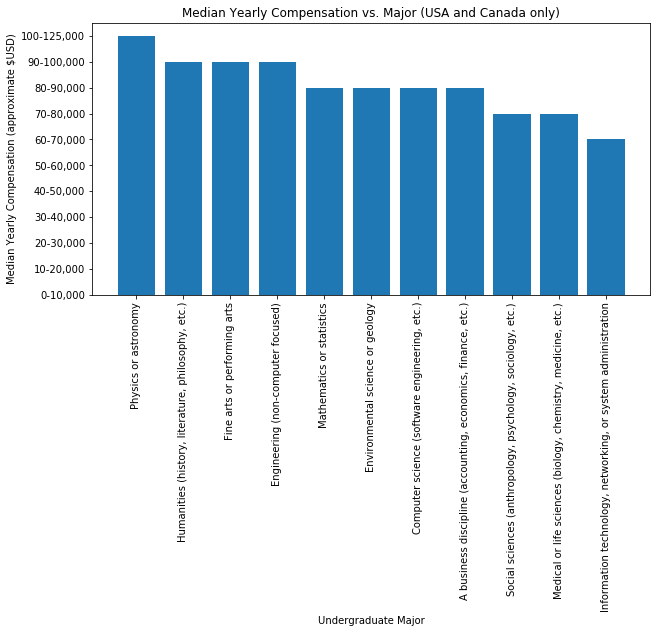

In [21]:
df_USA_CAN = df[df['Q3'].isin(['United States of America','Canada'])]
medsalbymajor = df_USA_CAN.groupby(['Q5'])['Q9'].median().sort_values(ascending = False)
majorlabels = list(medsalbymajor.to_dict().keys())
medsalbymajor = medsalbymajor.values
_ = plt.figure(figsize = (10,5))
_ = plt.title("Median Yearly Compensation vs. Major (USA and Canada only)")
_ = plt.xlabel("Undergraduate Major")
_ = plt.xticks(rotation = 'vertical')
_ = plt.ylabel("Median Yearly Compensation (approximate $USD)")
_ = plt.yticks(np.arange(18), salaryBins)
_ = plt.bar(x = majorlabels, height = medsalbymajor)

Here I take a look at the pairwise correlation between the features and the yearly compensation label.  Features with a higher correlation means that it has more relationship to what the target label will be, which could be interpreted as the feature importance.  We see that Q2, the age is the most important feature followed by whether the surveyee is from USA, is a student, is from India, or has used Amazon Web Service.  As you can see, this allows us to identify features that are important which might not be obvious like with the case of if the surveyee had used Amazon Web Service or whether if they "Build prototypes to explore applying machine learning to new areas".  

In [22]:
df3 = features
df3['Yearly Compensation'] = labels

In [23]:
cor = df3.corr()
cor_target = abs(cor['Yearly Compensation'])
relevant_features = cor_target[cor_target>0.01].sort_values(ascending = False)
topFeatsLabels = list(relevant_features.to_dict().keys())[1:50]
topFeats = relevant_features.values[1:50]

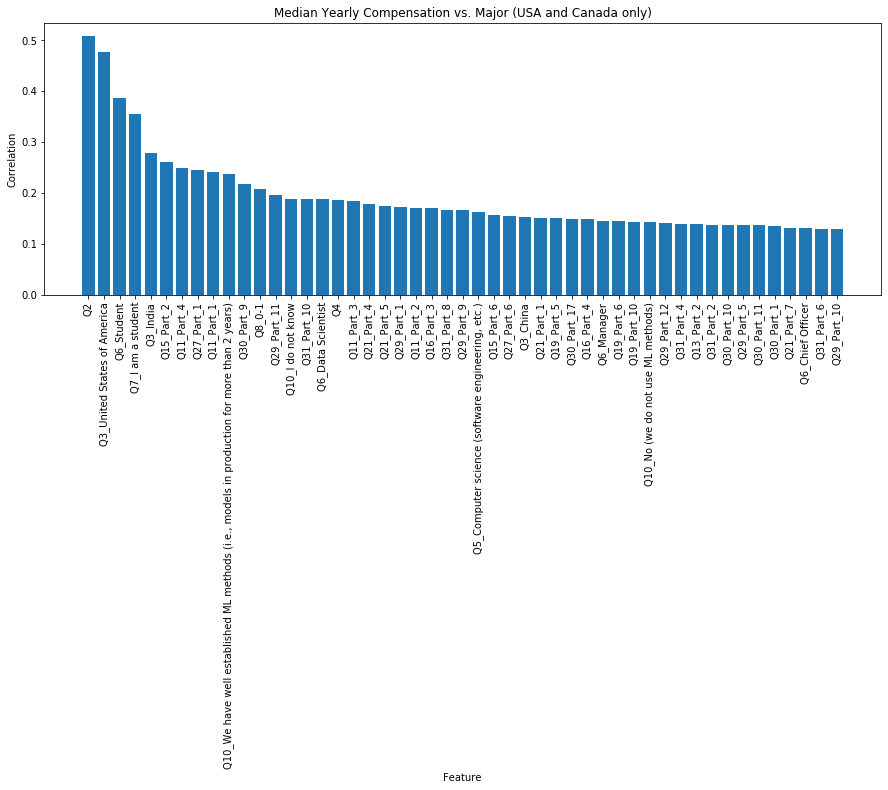

In [24]:
_ = plt.figure(figsize = (15,5))
_ = plt.title("Median Yearly Compensation vs. Major (USA and Canada only)")
_ = plt.xlabel("Feature")
_ = plt.xticks(rotation = 'vertical')
_ = plt.ylabel("Correlation")
_ = plt.bar(x = topFeatsLabels, height = topFeats)

Here I use a heat map to visualize the correlation between not only the features and target, but between features as well.  You can see  Q7 and Q6 is highly correlated (0.69) if the surveyee answered "Student" for both, which makes sense.  Also Q27_Part_1 and Q15_Part_2 is highly correlated (0.63) because one asks if the user uses AWS Elastic Compute Cloud (EC2) and the other Amazon Web Services (AWS) which makes sense as they're likely to use both related Amazon service.  Looking at the correlation can help us with feature reduction by removing a feature with high correlation to another as it is redundant.  

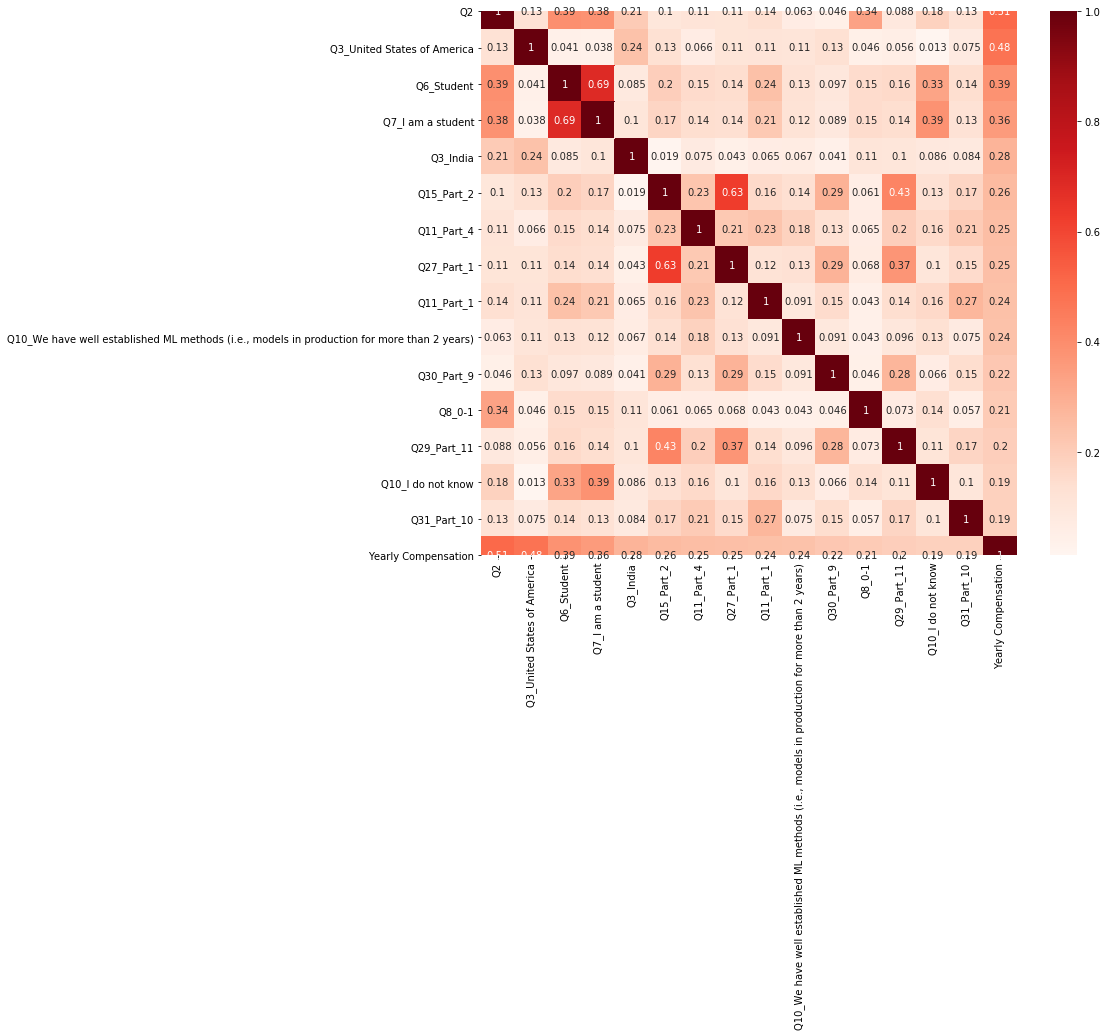

In [25]:
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df3[topFeatsLabels[0:15] + ['Yearly Compensation']].corr()
sns.heatmap(abs(cor), annot=True, cmap=plt.cm.Reds)
plt.show()

# 3. Feature Selection

Now I will perform feature selection. Feature selection is important because it reduces overfitting by removing redundant data, improves accuracy by removing noisy unrelated features, and reduce training time by reducing the dimensions the model needs to fit to.

Now I will discuss my reasoning behind feature scaling.  Most of my features are binary so it is not required to scale those features as already have a set range and unit variance.  For the ordinary categorical features, I decided to use MinMaxScaler to set the range to [0,1] because I will be using regularization for feature selection and model training.  If the features are not scaled, the regularizer would penalize the binary features more as they would have naturally larger parameters since their values are smaller.

In [26]:
from sklearn.preprocessing import MinMaxScaler
try:
    features = features.drop('Yearly Compensation', axis = 1)
except:
    pass
X = np.float64(features.values)
y = labels.values
# Scale the 2 ordinary columns (age and degree) using Min Max Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X[:,[1,2]] = scaler.fit_transform(X[:,[1,2]])

In [27]:
print("Number of features: ", X.shape[1])

Number of features:  355


Now I will manually one drop feature from each pair of features that are highly correlated we saw in section 2 since one of them would not cause much loss of information. I will drop the one with lower correlation with our target as that one is "less important".

In [28]:
X = np.delete(X, [93,327], 1)
print("Number of features: ", X.shape[1])

Number of features:  353


Here I used sklearn's SelectKBest method to reduce features down to the 100 features having highest correlation with the target by using the ANOVA F-test.  The con of this feature selection method is that it can only detect strong correlation if the features are linearly related to the target label. 

In [29]:
# Use SelectKBest to reduce number of features down to 100
from sklearn.feature_selection import SelectKBest, f_classif
k_best = SelectKBest(score_func=f_classif, k=100)
X = k_best.fit_transform(X, y)
print("Number of features: ", X.shape[1])

Number of features:  100


Here I use L1 regularizer with logistic regression model to shrink some parameters of features to exactly zero.  I am using the one-vs-rest scheme to do the multiclass classification which will return a parameter matrix of D features by K target categories.  Since different classifiers would put different weightings on features, I chose a threshold that if more than 10 of the 18 classifiers decided a parameter's weight is 0, I dropped those features.  

In [30]:
from sklearn.linear_model import LogisticRegression
L1 = LogisticRegression(random_state = 0, penalty = 'l1', solver='liblinear', multi_class = 'ovr').fit(X, y)
wgtMatrix = L1.coef_
sumWMNan = np.count_nonzero(wgtMatrix == 0, axis = 0) # Sum up how many classifiers dropped each feature
dropFeats = np.where(sumWMNan >= 10, True , False) # Determine features where more than 10 classifiers dropped it
dropFeats = np.argwhere(dropFeats).reshape(-1,)
X = np.delete(X, dropFeats, axis = 1) # Drop features
print("Number of features: ", X.shape[1])

Number of features:  96


Here we use principal component analysis to reduce the dimensions by projecting data from a high dimensional manifold to a lower dimension while retaining 90% of the variance. The con with this method is that it makes it difficult to explain the features of importance and the machine learning model will be more of a black box.

In [31]:
# Use PCA to reduce dimensionality of features
from sklearn.decomposition import PCA
pca = PCA(0.90)
X = pca.fit_transform(X)
print("Number of features: ", X.shape[1])

Number of features:  56


# 4. Model Implementation

In [32]:
# Standardize the features 
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()
X = stdscaler.fit_transform(X)

After feature selection, I then implemented the Logistic Regression model.  I used L2 regularization to prevent overfitting by encouraging the weights to take on smaller values.  Since I am using a regularizer, I need to scale my features first using standardization so that all the weights are penalized fairly.  The classification scheme is one-vs-rest which treats each target category  as a binary classification problem and returns an array of probabilities of the sample vector belonging to any of the target classes.  This however, is not the best way to model the dataset since the target salaries are ordinary but one-vs-rest assumes that the classes are independent.  But there is no logistic regression model in sklearn designed for ordinal logistic regression.  There is a package called Mord which does support it but I was getting some strange results with it so I decided to stick with Ovr.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) # Split the data to 70% training and 30% test.  I have 8539 samples > 5000.
print("Training samples:", X_train.shape[0])
clf = LogisticRegression(penalty = 'l2', C = 1, random_state = 0, multi_class = 'ovr', solver = 'liblinear')
_ = clf.fit(X_train, y_train)

Training samples: 8539


Here I used cross validation to verify that my training accuracy is consistent across subsets of my data to see if there are signs of overfitting.  The mean average of the scores is 33.4% and the variance is very low at 0.0001 which indicates the model performs consistently across the folds, indicated that there is unlikely to be overfitting.

In [34]:
from sklearn.model_selection import cross_val_score
# cvScores = cross_val_score(clf, X_train, y_train, cv = 10) # commented out to save compute time

# meanScores = np.mean(cvScores)
# varScores = np.var(cvScores)

# print("Average (mean) of cross-validation accuracies:", meanScores)
# print("Variance of cross-validation accuracies:", varScores)

Average (mean) of cross-validation accuracies: 0.33355409455819796
Variance of cross-validation accuracies: 0.00011219208156982836

Here I do cross validation again but each time using a different hyperparameter "C" (1/lambda) which controls the strength of the L2 regularizer.  The lowest C that attained the highest accuracy was C = 500, therefore I tuned my model by using that as my new C value. 

In [35]:
meanScores2 = []

# Use for loop to find best mean cross validation accuracy 
# Commented out to save compute time
# for C in [1, 10, 100, 500, 1000]:
#     clf2 = LogisticRegression(penalty = 'l2', C = C, random_state = 0, multi_class = 'ovr', solver = 'liblinear')
#     score = cross_val_score(clf2, X_train, y_train, cv = 10).mean()*100
#     print("Mean accuracy with C = :", C, score, "%")
#     meanScores2.append(score)

Mean accuracy with C = : 1 33.379116567889945 %
Mean accuracy with C = : 10 33.37892510803698 %
Mean accuracy with C = : 100 33.355409455819796 %
Mean accuracy with C = : 500 33.36718801883511 %
Mean accuracy with C = : 1000 33.36718801883511 %

# 5. Model Tuning

Another way to tune the model other than using a for loop is by using grid search.  Grid search allows you to test one classifier for each combination of hyperparameters you specify.  Here I do it only on C with 5 folds, I also wanted to try another hyperparameter "multi_class" with both ovr and multinomial but it was very problematic to get multinomial to converge because ovr and work with different solvers.  I am using f1 score because the accuracy could be misleading since my data in imbalanced.  Using f1 score incorporates the recall and precision which will tell me how well my model detects uncommon classes (high salaries) or how precise it's predictions are.  Below is a dataframe summarizing the results of the grid search.  Please take a look at "mean_test_score", we can see this time C=1 actually performed the best based on precision. Therefore I will change the model accordingly.  Note I commented out the grid search as it takes a long time to run, I just assigned the json data to the variable instead. 

In [36]:
# User grid search to tune model
from sklearn.model_selection import GridSearchCV
gSearch = GridSearchCV(estimator = clf, param_grid = {'C':[1, 10, 100, 500, 1000]}, cv = 5, scoring = 'f1_micro', return_train_score = True)
#gSearch = gSearch.fit(X_train, y_train)
#gSearchresults = pd.DataFrame.from_dict(gSearch.cv_results_)
gSearchresults = pd.DataFrame.from_dict({"mean_fit_time":{"0":1.443615675,"1":1.8693957806,"2":2.0978197098,"3":2.2591824055,"4":2.3079802513},"std_fit_time":{"0":0.0581809535,"1":0.0723862901,"2":0.1200767599,"3":0.156312763,"4":0.2021026925},"mean_score_time":{"0":0.0340532303,"1":0.0069215298,"2":0.0113801956,"3":0.0036457062,"4":0.0052323818},"std_score_time":{"0":0.03143288,"1":0.0026129897,"2":0.0094822137,"3":0.0009667323,"4":0.0034723264},"param_C":{"0":1,"1":10,"2":100,"3":500,"4":1000},"params":{"0":{"C":1},"1":{"C":10},"2":{"C":100},"3":{"C":500},"4":{"C":1000}},"split0_test_score":{"0":0.3282798834,"1":0.3259475219,"2":0.3253644315,"3":0.3247813411,"4":0.3247813411},"split1_test_score":{"0":0.3278784337,"1":0.3290473407,"2":0.3278784337,"3":0.3272939801,"4":0.3272939801},"split2_test_score":{"0":0.3257309942,"1":0.3251461988,"2":0.3233918129,"3":0.3228070175,"4":0.3228070175},"split3_test_score":{"0":0.3403755869,"1":0.3409624413,"2":0.3403755869,"3":0.3403755869,"4":0.3403755869},"split4_test_score":{"0":0.334902884,"1":0.3354914656,"2":0.3343143025,"3":0.333725721,"4":0.333725721},"mean_test_score":{"0":0.331420541,"1":0.3313034313,"2":0.3302494437,"3":0.3297810048,"4":0.3297810048},"std_test_score":{"0":0.0054215612,"1":0.0060399449,"2":0.0062519182,"3":0.0064416469,"4":0.0064416469},"rank_test_score":{"0":1,"1":2,"2":3,"3":4,"4":4},"split0_train_score":{"0":0.3672332943,"1":0.3685521688,"2":0.3694314185,"3":0.3694314185,"4":0.3694314185},"split1_train_score":{"0":0.3658465144,"1":0.3670181605,"2":0.3676039836,"3":0.3674575278,"4":0.3673110721},"split2_train_score":{"0":0.3622785181,"1":0.3627178211,"2":0.3627178211,"3":0.3627178211,"4":0.3627178211},"split3_train_score":{"0":0.3603511339,"1":0.3606437454,"2":0.3607900512,"3":0.3606437454,"4":0.3606437454},"split4_train_score":{"0":0.3660818713,"1":0.3668128655,"2":0.366374269,"3":0.3665204678,"4":0.3665204678},"mean_train_score":{"0":0.3643582664,"1":0.3651489523,"2":0.3653835087,"3":0.3653541961,"4":0.365324905},"std_train_score":{"0":0.0026013053,"1":0.0029682223,"2":0.0031781577,"3":0.0032108178,"4":0.0031921098}})

In [37]:
gSearchresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.443616,0.058181,0.034053,0.031433,1,{'C': 1},0.328280,0.327878,0.325731,0.340376,...,0.331421,0.005422,1,0.367233,0.365847,0.362279,0.360351,0.366082,0.364358,0.002601
1,1.869396,0.072386,0.006922,0.002613,10,{'C': 10},0.325948,0.329047,0.325146,0.340962,...,0.331303,0.006040,2,0.368552,0.367018,0.362718,0.360644,0.366813,0.365149,0.002968
2,2.097820,0.120077,0.011380,0.009482,100,{'C': 100},0.325364,0.327878,0.323392,0.340376,...,0.330249,0.006252,3,0.369431,0.367604,0.362718,0.360790,0.366374,0.365384,0.003178
3,2.259182,0.156313,0.003646,0.000967,500,{'C': 500},0.324781,0.327294,0.322807,0.340376,...,0.329781,0.006442,4,0.369431,0.367458,0.362718,0.360644,0.366520,0.365354,0.003211
4,2.307980,0.202103,0.005232,0.003472,1000,{'C': 1000},0.324781,0.327294,0.322807,0.340376,...,0.329781,0.006442,4,0.369431,0.367311,0.362718,0.360644,0.366520,0.365325,0.003192


# 6. Testing & Discussion

Finally, I tested the model on an isolated test dataset.  The accuracy of the test set is 2% lower than with the training set which is expected and shows that the model is not overfitting. If it was overfit, the training accuracy would be much higher than the test accuracy, meaning the model picked up small specific idiosyncracies in the data rather than a more generalized fit.  But again, this is not the case.  The accuracy is also identical to the recall and precision.  This is because the recall and precision sums up all the tp, fp, and fn from all the classifiers so it balances out.  

In [38]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

trainAccuracy = clf.score(X_train, y_train)
testAccuracy = clf.score(X_test, y_test)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

testRecall = recall_score(y_test, y_pred_test, average = 'micro')
testPrecision = precision_score(y_test, y_pred_test, average = 'micro')
testf1 = f1_score(y_test, y_pred_test, average = 'micro')

trainRecall = recall_score(y_train, y_pred_train, average = 'micro')
trainPrecision = precision_score(y_train, y_pred_train, average = 'micro')
trainf1 = f1_score(y_train, y_pred_train, average = 'micro')

print("Test Accuracy: ", testAccuracy)
print("Train Accuracy: ", trainAccuracy)
print("Test Recall: ", testRecall)
print("Train Recall: ", trainRecall)
print("Test Precision: ", testPrecision)
print("Train Precision: ", trainPrecision)
print("Test F1 Score: ", testf1)
print("Train F1 Score: ", trainf1)

Test Accuracy:  0.34234972677595626
Train Accuracy:  0.3603466448061834
Test Recall:  0.34234972677595626
Train Recall:  0.3603466448061834
Test Precision:  0.34234972677595626
Train Precision:  0.3603466448061834
Test F1 Score:  0.34234972677595626
Train F1 Score:  0.3603466448061834


Here I took a look at the distribution of labels that my model got incorrect and correct.  As suspected, my model is really good at predicting the 0-10000 class as 29% of my samples were that class.  The accuracy would be better if my data was less sparse.  Another way to deal with data sparsity is by using the Bayesian Parameter Estimation which treats the parameters as random variables and less influenced by how frequent each target class is.

In [39]:
corrects = (y_pred_test == y_test)
corrects1 = np.where(corrects, y_test, -100)
corrects1 = corrects1[corrects1 != -100]
wrongs = np.where(corrects, 100, y_test)
wrongs = wrongs[wrongs != 100]

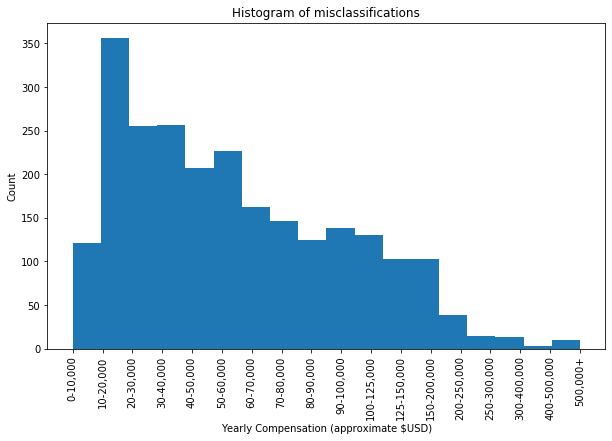

In [40]:
_ = plt.figure(figsize = (10,6))
_ = plt.title("Histogram of misclassifications")
_ = plt.xlabel("Yearly Compensation (approximate $USD)")
_ = plt.xticks(np.arange(18), salaryBins, rotation='vertical')
_ = plt.ylabel("Count")
_ = plt.hist(wrongs, bins = 18)

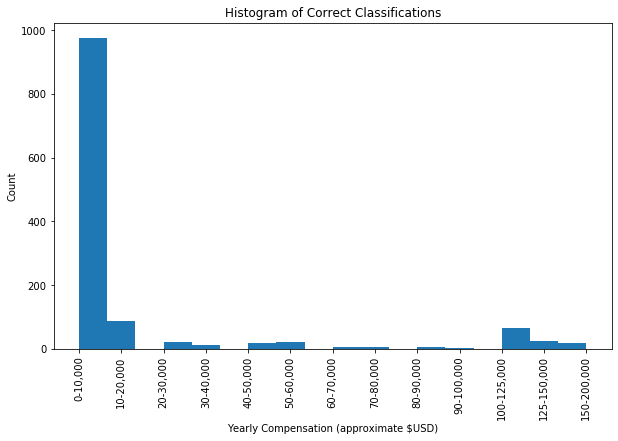

In [41]:
_ = plt.figure(figsize = (10,6))
_ = plt.title("Histogram of Correct Classifications")
_ = plt.xlabel("Yearly Compensation (approximate $USD)")
_ = plt.xticks(np.arange(18), salaryBins, rotation='vertical')
_ = plt.ylabel("Count")
_ = plt.hist(corrects1, bins = 18)

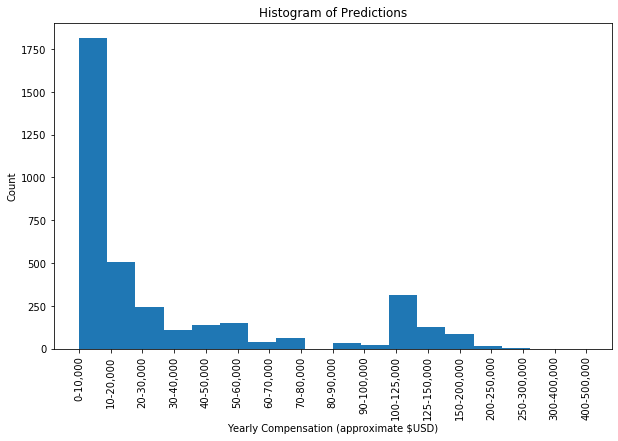

In [42]:
_ = plt.figure(figsize = (10,6))
_ = plt.title("Histogram of Predictions")
_ = plt.xlabel("Yearly Compensation (approximate $USD)")
_ = plt.xticks(np.arange(18), salaryBins, rotation='vertical')
_ = plt.ylabel("Count")
_ = plt.hist(y_pred_test, bins = 18)